# LeRobot Dataset Analysis

This notebook contains examples for analyzing and filtering the LeRobot dataset metadata CSV.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Read the CSV file
df = pd.read_csv('../lerobot_datasets.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
df.info()

Dataset Shape: (1001, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   repo_id         1001 non-null   object
 1   username        1001 non-null   object
 2   robot_type      975 non-null    object
 3   total_episodes  1001 non-null   int64 
 4   total_frames    1001 non-null   int64 
 5   fps             1001 non-null   int64 
 6   camera_keys     981 non-null    object
 7   num_cameras     1001 non-null   int64 
 8   video_keys      959 non-null    object
 9   has_video       1001 non-null   bool  
 10  total_tasks     1001 non-null   int64 
 11  tasks           1001 non-null   object
 12  is_sim          1001 non-null   bool  
 13  is_eval         1001 non-null   bool  
 14  features        1001 non-null   object
 15  chunks_size     1001 non-null   int64 
 16  total_chunks    1001 non-null   int64 
 17  version         1001 non-n

## Basic Filtering Examples

In [3]:
# Filter for datasets with significant data
qualified_datasets = df[
    (df['total_episodes'] >= 10) &  # At least 10 episodes
    (df['total_frames'] >= 1000) &  # At least 1000 frames
    (df['has_video'] == True) &     # Must have video
    (df['is_sim'] == False)         # Real robot data only
]

print(f"Original datasets: {len(df)}")
print(f"Qualified datasets: {len(qualified_datasets)}")

# Show distribution by robot type
print("\nDistribution by robot type:")
print(qualified_datasets['robot_type'].value_counts())

Original datasets: 1001
Qualified datasets: 515

Distribution by robot type:
robot_type
so100               195
unknown              87
koch                 77
arx5                 30
aloha                28
arx5_bimanual        23
koch_bimanual        22
moss                 12
piper                 5
reachy2               4
myarm                 4
so100_bimanual        4
so100_ws              2
koch_k1               1
KIA Niro EV 2023      1
stretch               1
Franka                1
aloha-stationary      1
mycobot               1
bi_ur5                1
so-100                1
mcx                   1
piper_bimanual        1
Name: count, dtype: int64


## Analyzing Camera Configurations

In [4]:
# Look at camera configurations
camera_analysis = qualified_datasets.groupby(['robot_type', 'camera_keys']).size().reset_index(name='count')
print("Camera configurations by robot type:")
print(camera_analysis)

Camera configurations by robot type:
           robot_type                                        camera_keys  \
0              Franka   observation.images.head,observation.images.wrist   
1    KIA Niro EV 2023  observation.images.front_left,observation.imag...   
2               aloha  observation.images.cam_high,observation.images...   
3               aloha  observation.images.cam_high,observation.images...   
4               aloha  observation.images.cam_high,observation.images...   
..                ...                                                ...   
102           unknown  observation.images.left_wrist,observation.imag...   
103           unknown  observation.images.rgb_static,observation.imag...   
104           unknown  observation.images.top_image,observation.image...   
105           unknown                          observation.images.webcam   
106           unknown  observation.images.wrist_image,observation.ima...   

     count  
0        1  
1        1  
2       12 

## Dataset Size Analysis

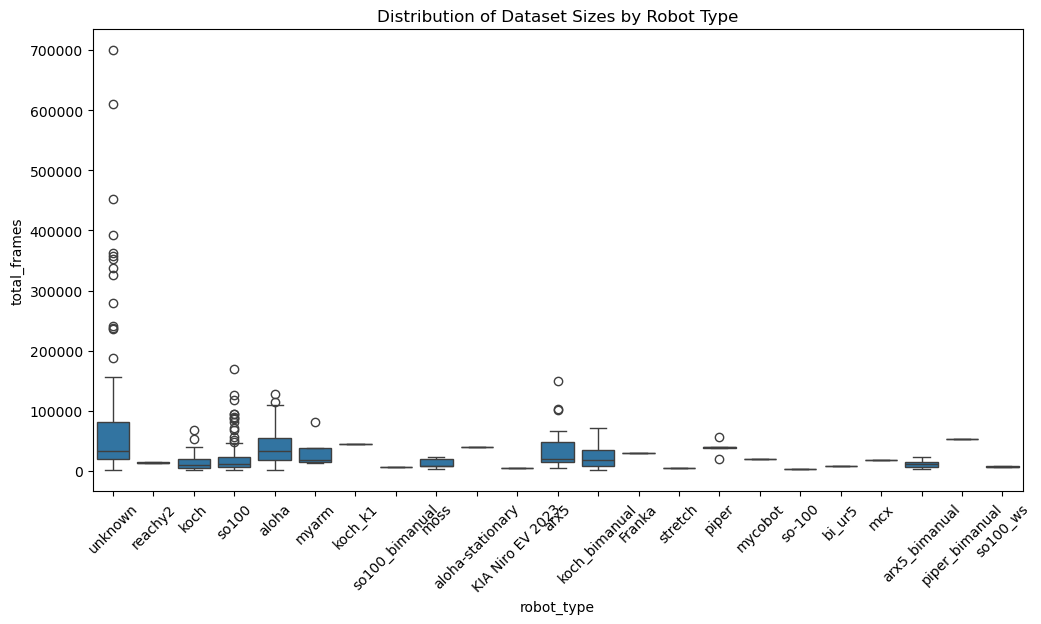

In [5]:
# Create size distribution plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=qualified_datasets, x='robot_type', y='total_frames')
plt.xticks(rotation=45)
plt.title('Distribution of Dataset Sizes by Robot Type')
plt.show()

## Task Analysis

In [7]:
# Function to parse tasks JSON and check validity
def analyze_tasks(tasks_json):
    try:
        tasks = json.loads(tasks_json)
        valid_tasks = [task for task in tasks.values() 
                      if task and isinstance(task, str) and len(task.strip()) > 3]
        return len(valid_tasks) > 0
    except:
        return False

# Add task validity column
qualified_datasets['has_valid_tasks'] = qualified_datasets['tasks'].apply(analyze_tasks)

# Filter for datasets with valid tasks
valid_task_datasets = qualified_datasets[qualified_datasets['has_valid_tasks']]

print(f"Datasets with valid tasks: {len(valid_task_datasets)} out of {len(qualified_datasets)}")

Datasets with valid tasks: 488 out of 515


/tmp/ipykernel_2078293/3620805809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_datasets['has_valid_tasks'] = qualified_datasets['tasks'].apply(analyze_tasks)


## User Contribution Analysis

In [8]:
# Analyze contributions by user
user_contributions = valid_task_datasets.groupby('username').agg({
    'repo_id': 'count',
    'total_episodes': 'sum',
    'total_frames': 'sum'
}).rename(columns={'repo_id': 'num_datasets'})

print("Top contributors by number of datasets:")
print(user_contributions.sort_values('num_datasets', ascending=False).head())

Top contributors by number of datasets:
                num_datasets  total_episodes  total_frames
username                                                  
lerobot                   71           56999       7037208
villekuosmanen            64            3475       2375549
RobotisSW                 26             640        175360
pranavsaroha              13             533        295241
0x00raghu                 12             194        118604


In [11]:
username = 'villekuosmanen'
user_df = df[df['username'] == username]

summary_df = user_df[['repo_id', 'total_episodes', 'robot_type']].sort_values('total_episodes', ascending=False)

# Display nicely formatted
print(f"\nDatasets for {username}:")
print(summary_df.to_string(index=False))

# Print totals
print(f"\nTotal datasets: {len(user_df)}")
print(f"Total episodes: {user_df['total_episodes'].sum():,}")


Datasets for villekuosmanen:
                                        repo_id  total_episodes    robot_type
      villekuosmanen/pick_coffee_capsule_merged             770       unknown
  villekuosmanen/pick_coffee_prop_center_merged             200       unknown
              villekuosmanen/dAgger_coffee_prop             170          arx5
          villekuosmanen/move_objects_multitask             140          arx5
       villekuosmanen/pick_coffee_prop_20Hz_alt             100          arx5
              villekuosmanen/rice-cooker_step_0             100       unknown
           villekuosmanen/pick_coffee_prop_20Hz             100          arx5
                      villekuosmanen/pack_shoes             100       unknown
              villekuosmanen/rice-cooker_step_3             100       unknown
              villekuosmanen/rice-cooker_step_2             100       unknown
                   villekuosmanen/close_shoebox              99       unknown
  villekuosmanen/rice-cooker_step_

## Export Filtered Results

In [ ]:
# Export the final filtered dataset list
final_datasets = valid_task_datasets[['repo_id', 'robot_type', 'total_episodes', 'total_frames', 'camera_keys']]
final_datasets.to_csv('qualified_datasets.csv', index=False)
print("Saved qualified datasets to 'qualified_datasets.csv'")